代币总供应量: 10000000000


内盘初始价格: 8e-06
内盘最终价格: 8e-05
内盘代币供应量: 8500000000
内盘打满成本（UB）: 265216.5522512564
内盘最终市值（UB）: 800000.0000000001


流动性池代币数量: 1500000000
流动性池初始价格: 0.00017681103483417095
流动性池价格计算初始市值（UB）: 1768110.3483417095


控盘成本估算:
90.0% (85.0% 内盘 + 5.000000000000004% 通过 LP 买入): 265216.5522512564 + 132608.27612562838
全额卖出磨损 (UB)：72331.78697761544

95.0% (85.0% 内盘 + 9.999999999999998% 通过 LP 买入): 265216.5522512564 + 530433.1045025125
全额卖出磨损 (UB)：165760.34515703516

98.0% (85.0% 内盘 + 13.0% 通过 LP 买入): 265216.5522512564 + 1723907.5896331668
全额卖出磨损 (UB)：442027.5870854275



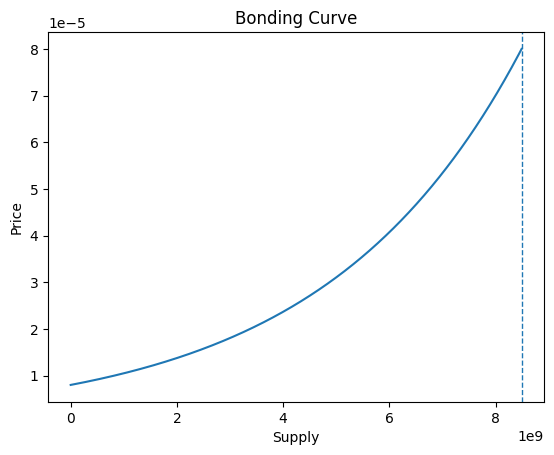

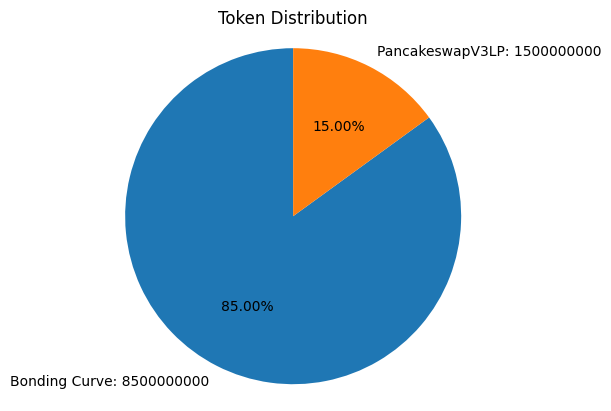

In [3]:
"""
Author: yoosoftcc
Time: 2025/02/17 18:02:30
Desc: 联合曲线示例
"""

import numpy as np
from matplotlib import pyplot

"""
目前项目采用的是比较广泛应用的 Discrete bonding curve （DBC 模型，离散型联合曲线），即带价格阶梯的联合曲线
指数型 DBC 模型也是 pumpfun 等平台最常见的实现，https://blog.slerf.tools/solana-pump-fun-and-bonding-curve/

常见函数类型：
    线性函数：恒定金额做市商
    指数函数：恒定市场做市商
    Log 函数：恒定均值做市商
    变异函数：恒定交换不变性做市商

示例代码中的可配置参数
价格/内盘供应量 曲线：
    可配置参数 - startingPrice，targetPrice， stepCount，targetMcap
代币分配饼图：
    可配置参数 - maxSupply
"""

# launch fee (1 UB)
launch_fee = 0

# 初始价格（UB）
startingPrice = 0.000008

# 1000 个价格阶梯
stepCount = 1000

# 内盘目标价格 （WBNB）
targetPrice = 0.00008

# # 内盘目标市值（WBNB）
# targetMcap = 100

# 最大供应量：10B
maxSupply = 10_000_000_000

# 内盘供应量：8.5B
supplyAtCurve = 8_500_000_000 

# 允许创建者分配 token，即创建同时捆版买入，默认为 0
creatorAllocation = 0

# 每个价格阶梯对应 x 轴供应量的跨度
deltaX = (supplyAtCurve - creatorAllocation) / stepCount

# x 轴总跨度
totalX = supplyAtCurve - creatorAllocation - deltaX

# y 轴总跨度
totalY = targetPrice - startingPrice

percentageIncrease = pow(targetPrice / startingPrice, 1 / (stepCount - 1))
index = np.arange(0, stepCount)

# x 轴供应量
x = index * deltaX + creatorAllocation

# y 轴价格
y = [startingPrice]

# 储备代币数量 WBNB
reserve = 0
for lp_bought_percent in range(1, len(index)):
    prevY = y[lp_bought_percent - 1]
    currY = prevY * percentageIncrease
    y.append(currY)
    reserve += deltaX * prevY

print('代币总供应量:', maxSupply)
print('\n')
print('内盘初始价格:', startingPrice)
print('内盘最终价格:', targetPrice)
print('内盘代币供应量:', supplyAtCurve)
print('内盘打满成本（UB）:', reserve)
print('内盘最终市值（UB）:', maxSupply * targetPrice)
print('\n')
initial_lp_price = (reserve - launch_fee) / (maxSupply - supplyAtCurve)

lp_token_supply = maxSupply - supplyAtCurve
print('流动性池代币数量:', lp_token_supply)
print('流动性池初始价格:', initial_lp_price)
print('流动性池价格计算初始市值（UB）:', maxSupply * initial_lp_price)

print('\n\n控盘成本估算:')
lp_wbnb_reserve = reserve
percent_at_curve = supplyAtCurve / maxSupply
# 控盘筹码 90%, 95%, 98%
for lp_bought_percent in [0.9 - percent_at_curve, 0.95 - percent_at_curve, 0.98 - percent_at_curve]:
    lp_wbnb_used = (lp_wbnb_reserve * (lp_bought_percent * maxSupply)) / (lp_token_supply - (lp_bought_percent * maxSupply))
    print(f'{(percent_at_curve + lp_bought_percent) * 100}% ({(percent_at_curve * 100)}% 内盘 + {lp_bought_percent * 100}% 通过 LP 买入): {lp_wbnb_reserve} + {lp_wbnb_used}')
    
    new_lp_token_supply = lp_token_supply + (lp_bought_percent * maxSupply)
    new_lp_wbnb_reserve = lp_wbnb_reserve + lp_wbnb_used
    lp_token_amount_to_sold = maxSupply * (percent_at_curve + lp_bought_percent) 
    lp_wbnb_sold = (new_lp_wbnb_reserve * lp_token_amount_to_sold) / (new_lp_token_supply + lp_token_amount_to_sold)
    print(f'全额卖出磨损 (UB)：{new_lp_wbnb_reserve - lp_wbnb_sold}\n')

# style 为 plain 即 禁用科学计数法格式，但有些长
ax = pyplot.gca()
ax.ticklabel_format(style='sci', axis='y')
ax.ticklabel_format(style='sci', axis='x')

pyplot.title("Bonding Curve")
pyplot.xlabel("Supply")
pyplot.ylabel("Price")
pyplot.plot(x, y)
pyplot.axvline(supplyAtCurve, linewidth=1, linestyle='--')
pyplot.show()

# 价格需要确保从内盘平移至 LP池，即价格模型从 bonding curve 转变为 x*y=k AMM
# 代币分配见饼图
lpWBNB = reserve - launch_fee
lpToken =  maxSupply - supplyAtCurve
pyplot.pie([supplyAtCurve, lpToken],
           labels=[f"Bonding Curve: {int(supplyAtCurve)}", f"PancakeswapV3LP: {int(lpToken)}"], autopct='%1.2f%%', startangle=90)
pyplot.axis('equal')
pyplot.title('Token Distribution')
pyplot.show()